In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re

In [47]:
# Connessione al database SQL
conn = sqlite3.connect('database.db')
query_Y = "SELECT * FROM Y"  
Y = pd.read_sql_query(query_Y, conn)
query_Q = "SELECT * FROM Q"
Q = pd.read_sql_query(query_Q, conn)
# Chiusura della connessione
conn.close()

In [17]:
print(df_filtered)


      id   s_names n_names  th_names    values
0      1  baseline      EE    h1-wi1  0.591756
1      2  baseline      EE    h2-wi1  0.467176
2      3  baseline      EE    h3-wi1  0.404886
3      4  baseline      EE    h4-wi1  0.373741
4      5  baseline      EE    h5-wi1  0.389313
..   ...       ...     ...       ...       ...
956  957  baseline      EE  h21-su10  0.614115
957  958  baseline      EE  h22-su10  0.583713
958  959  baseline      EE  h23-su10  0.474267
959  960  baseline      EE  h24-su10  0.346580
960  961  baseline      EE    h_peak  1.899849

[961 rows x 5 columns]


In [32]:
# Funzione per modificare la colonna 'th_names'
def modify_th_names(th_name):
    # Aggiungere uno 0 tra 'h' e una cifra se dopo la lettera 'h' c'è solo una cifra prima di '-'
    th_name = re.sub(r'(h)(\d)(-)', r'\g<1>0\g<2>\g<3>', th_name)
    
    # Aggiungere uno 0 al penultimo posto se la stringa non finisce con '10'
    if not th_name.endswith('10'):
        th_name = th_name[:-1] + '0' + th_name[-1]
    
    return th_name

In [48]:
Y['th_names'] = Y['th_names'].apply(modify_th_names)
Q['th_names'] = Q['th_names'].apply(modify_th_names)

In [58]:
# Raggruppamento dei dati per 'n_names'
Y_filtered = Y[Y['n_names'] == 'Hot water']
Y_filtered=Y_filtered.iloc[:-1]
Q_filtered = Q[Q['n_names'] == 'Hot water']
Q_filtered=Q_filtered.iloc[:-1]

In [59]:
#Suddivisione in mesi
Y_filtered.loc[:,'season']=Y_filtered['th_names'].str[-4:-2]
Y_filtered['hour'] = Y_filtered['th_names'].str[1:3].astype(int)
Y_filtered['day'] = Y_filtered['th_names'].str[-2:].astype(int)
Y_filtered['time'] = (Y_filtered['day'] - 1) * 24 + Y_filtered['hour']

Q_filtered.loc[:,'season']=Q_filtered['th_names'].str[-4:-2]
Q_filtered['hour'] = Q_filtered['th_names'].str[1:3].astype(int)
Q_filtered['day'] = Q_filtered['th_names'].str[-2:].astype(int)
Q_filtered['time'] = (Q_filtered['day'] - 1) * 24 + Q_filtered['hour']

In [61]:
Yh_filtered = Y[Y['n_names'] == 'Heat']
Yh_filtered=Yh_filtered.iloc[:-1]
Yh_filtered.loc[:,'season']=Yh_filtered['th_names'].str[-4:-2]
Yh_filtered['hour'] = Yh_filtered['th_names'].str[1:3].astype(int)
Yh_filtered['day'] = Yh_filtered['th_names'].str[-2:].astype(int)
Yh_filtered['time'] = (Yh_filtered['day'] - 1) * 24 + Yh_filtered['hour']

In [53]:
print(Y_filtered)

      id   s_names n_names  th_names    values season  hour  day  time
0      1  baseline      EE  h01-wi01  0.591756     wi     1    1     1
1      2  baseline      EE  h02-wi01  0.467176     wi     2    1     2
2      3  baseline      EE  h03-wi01  0.404886     wi     3    1     3
3      4  baseline      EE  h04-wi01  0.373741     wi     4    1     4
4      5  baseline      EE  h05-wi01  0.389313     wi     5    1     5
..   ...       ...     ...       ...       ...    ...   ...  ...   ...
955  956  baseline      EE  h20-su10  0.693160     su    20   10   236
956  957  baseline      EE  h21-su10  0.614115     su    21   10   237
957  958  baseline      EE  h22-su10  0.583713     su    22   10   238
958  959  baseline      EE  h23-su10  0.474267     su    23   10   239
959  960  baseline      EE  h24-su10  0.346580     su    24   10   240

[960 rows x 9 columns]


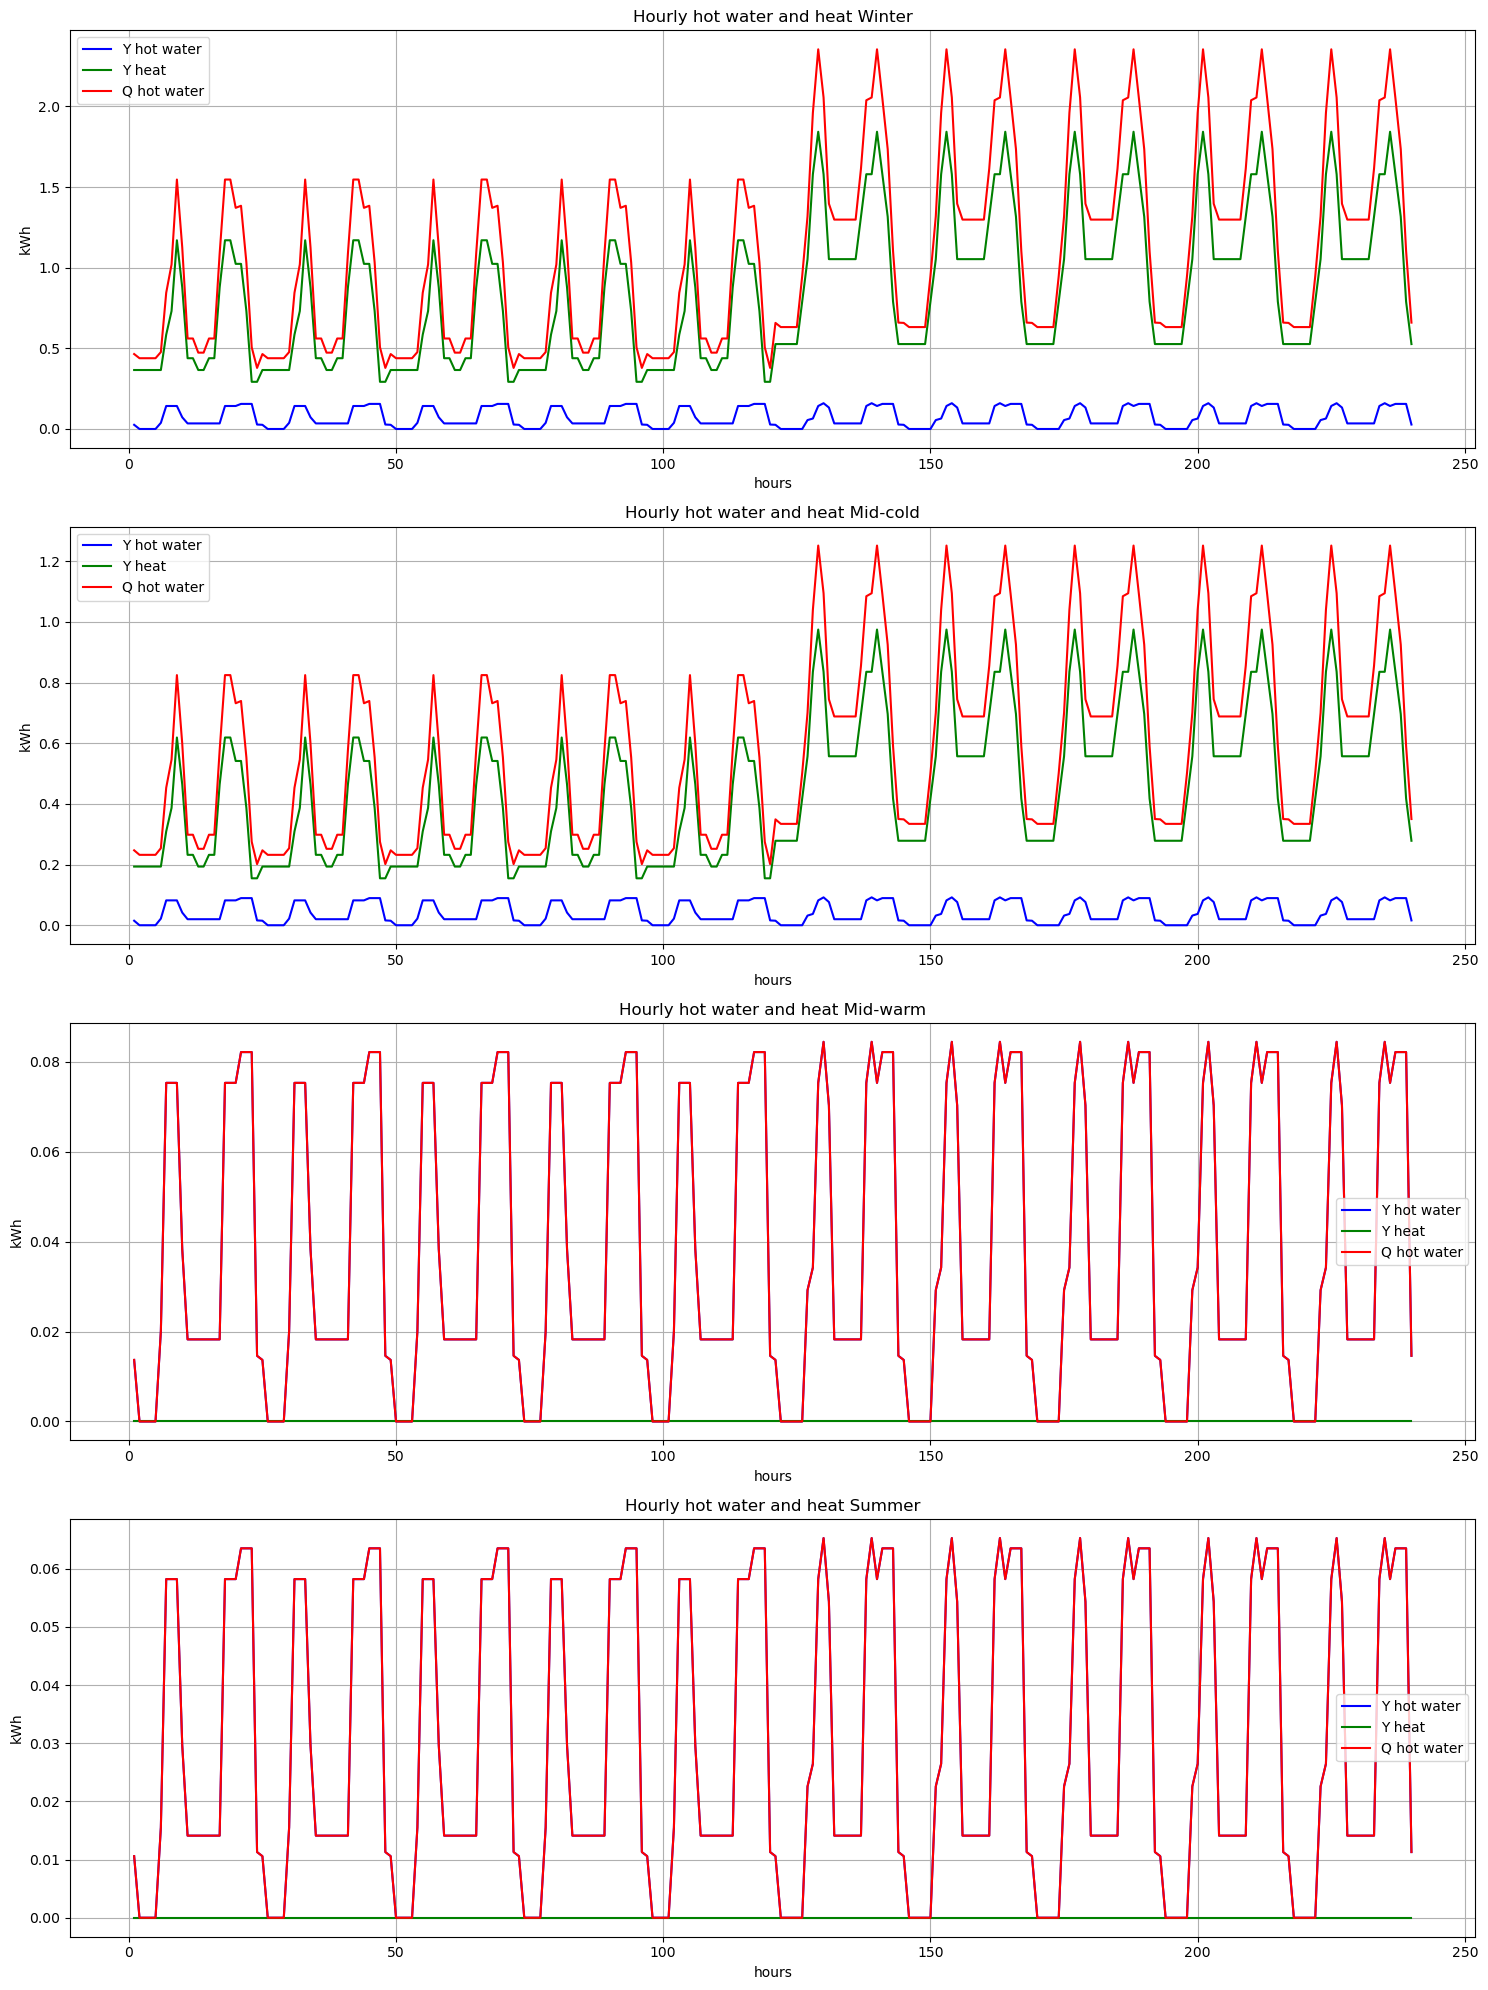

In [63]:
seasons = ['wi', 'mc', 'mw', 'su']
season_names = {'wi': 'Winter', 'mc': 'Mid-cold', 'mw': 'Mid-warm', 'su': 'Summer'}
# Creazione del grafico
plt.figure(figsize=(15, 20))

for i, season in enumerate(seasons, 1):
    Y_season = Y_filtered[Y_filtered['season'] == season]
    Yh_season = Yh_filtered[Yh_filtered['season'] == season]
    Q_season = Q_filtered[Q_filtered['season'] == season]
    
    plt.subplot(4, 1, i)
    plt.plot(Y_season['time'], Y_season['values'], label='Y hot water', color='blue')
    plt.plot(Yh_season['time'], Yh_season['values'], label='Y heat', color='green')
    plt.plot(Q_season['time'], Q_season['values'], label='Q hot water', color='red')
    plt.xlabel('hours')
    plt.ylabel('kWh')
    plt.title(f'Hourly hot water and heat {season_names[season]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()